In [141]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# read .cvs files
df = pd.read_csv('train.csv', nrows=1000)
test_df = pd.read_csv('test.csv')

In [142]:
# print descriptive statistics of the data, including mean, standard deviation, median, etc.
basic_info = df.describe()
print(basic_info)

             Index  Sentiment
count  1000.000000     1000.0
mean    499.500000        0.0
std     288.819436        0.0
min       0.000000        0.0
25%     249.750000        0.0
50%     499.500000        0.0
75%     749.250000        0.0
max     999.000000        0.0


In [143]:
# display the beginning X rows 
print("The data from the first 5 rows are: \n", df.head(5))

# display the bottom X rows 
print("The data from the last 5 rows are: \n", df.tail(5))

The data from the first 5 rows are: 
    Index  Sentiment                                               Text
0      0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1      1          0  is upset that he can't update his Facebook by ...
2      2          0  @Kenichan I dived many times for the ball. Man...
3      3          0    my whole body feels itchy and like its on fire 
4      4          0  @nationwideclass no, it's not behaving at all....
The data from the last 5 rows are: 
      Index  Sentiment                                               Text
995    995          0  @dkoenigs thanks man.  I'm so very grateful.  ...
996    996          0  @t_wolfe  i miss u too. i'm totally comin back...
997    997          0  @sniffinglue ohhh. I love it. ps I'm sad we di...
998    998          0          And somehow I still end up in this place 
999    999          0         @kisluvkis oh that is very sad, poor boy. 


In [144]:
# check for missin values; verdict = none
df.isna().sum()

Index        0
Sentiment    0
Text         0
dtype: int64

/var/folders/5k/sjwwd0rj5cx9swsd9y1mfdzm0000gn/T/ipykernel_78784/1400134019.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df['Sentiment'], palette='bright')


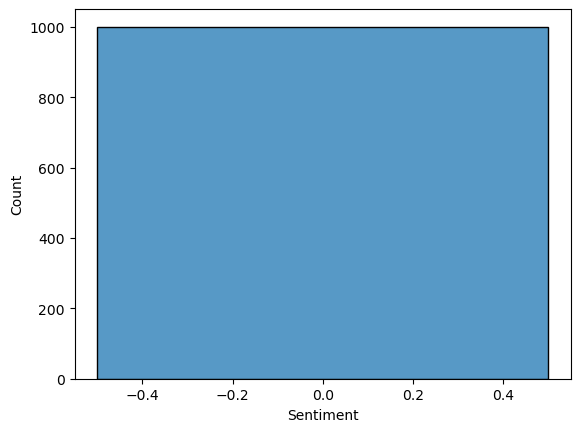

In [145]:
# distribution of negative and positive sentiments
sns.histplot(data=df['Sentiment'], palette='bright')
plt.show()
# much more negative than positive sentiments

# Preprocessing

In [146]:
import nltk
import contractions

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
nltk.download('stopwords');
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/yannalin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yannalin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yannalin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yannalin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [147]:
def tokenize(column):

    # remove '@', 'http', and contractions
    for word in column.split():
      if word.startswith('@'):
        column = column.replace(word, '')
      if word.startswith('http'):
        column = column.replace(word, '')
      if '\'' in word:
        column = column.replace(word, contractions.fix(word))
        # print (word, '->', contractions.fix(word))

    # tokenize, remove punctuation, then stem
    tokens = nltk.word_tokenize(column)
    expanded_tokens = []
    i = 0
    while i < len(tokens):
      # if tokens[i] not in stopwords.words('english'):
      if tokens[i].isalpha():
        expanded_tokens.append(lemmatizer.lemmatize(tokens[i].lower()))
      i += 1

    return expanded_tokens

In [148]:
df['Tokenized'] = df.apply(lambda x: tokenize(x['Text']), axis=1)
df[['Sentiment','Tokenized']].head()

,Sentiment,Tokenized
0,0,"[awww, that, is, a, bummer, you, shoulda, got,..."
1,0,"[is, upset, that, he, can, not, update, his, f..."
2,0,"[i, dived, many, time, for, the, ball, managed..."
3,0,"[my, whole, body, feel, itchy, and, like, it, ..."
4,0,"[no, it, is, not, behaving, at, all, i, am, ma..."
